In [67]:
import pandas as pd
import numpy as np
import random
from scipy import stats
from pokerlib import HandParser
from pokerlib.enums import Rank, Suit
from matplotlib import pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

## References used in this analysis

https://www.pokernews.com/casino/video-poker/ultimate-texas-holdem.htm

https://pypi.org/project/pokerlib/

# Setup game structure

In [2]:
# create deck
suits = [
    Suit.HEART, 
    Suit.DIAMOND, 
    Suit.SPADE, 
    Suit.CLUB
]
values = [
    Rank.TWO,
    Rank.THREE,
    Rank.FOUR,
    Rank.FIVE,
    Rank.SIX,
    Rank.SEVEN,
    Rank.EIGHT,
    Rank.NINE,
    Rank.TEN,
    Rank.JACK,
    Rank.QUEEN,
    Rank.KING,
    Rank.ACE
]

deck = [(value, suit) for value in values for suit in suits]

In [3]:
len(deck)

52

In [4]:
board = random.sample(deck, 9)
board

[(<Rank.FOUR: 2>, <Suit.CLUB: 1>),
 (<Rank.JACK: 9>, <Suit.SPADE: 0>),
 (<Rank.EIGHT: 6>, <Suit.CLUB: 1>),
 (<Rank.THREE: 1>, <Suit.DIAMOND: 2>),
 (<Rank.FIVE: 3>, <Suit.CLUB: 1>),
 (<Rank.JACK: 9>, <Suit.DIAMOND: 2>),
 (<Rank.ACE: 12>, <Suit.SPADE: 0>),
 (<Rank.NINE: 7>, <Suit.DIAMOND: 2>),
 (<Rank.NINE: 7>, <Suit.HEART: 3>)]

In [5]:
def set_board(deck):
    board = random.sample(deck, 9)
    
    my_hand = board[0:2]
    dealer_hand = board[2:4]
    flop = board[4:7]
    river = board[7:9]
    
    return(my_hand, dealer_hand, flop, river)


# Set Strategy

Strategy is copied from this blog post: https://www.pokernews.com/casino/video-poker/ultimate-texas-holdem.htm#best-ultimate-texas

In [6]:
def get_bet(ANTE, my_hand, flop, river):
    play = 0
    # Check if there is a hole pair
    if HandParser(my_hand).handenum >= 1:
        play = ANTE * 4

    # check if there is an ace in the personal cards
    elif my_hand[0][0].name == 'ACE' or my_hand[0][0].name == 'ACE':
        play = ANTE * 4

    # check if there is a king 5 or king suited in the personal cards
    elif my_hand[0][0].value == 11 or my_hand[0][0].value == 11:       # check if one of cards is a king
        if my_hand[0][0].value == 11:                                  # first card is a king
            if my_hand[1][0].value >= 3:                               # second card value is greater than or equal to 5
                play = ANTE * 4
            elif my_hand[0][1].value == my_hand[1][1].value:           # second card is suited with first
                play = ANTE * 4

        if my_hand[1][0].value == 11:                                  # second card is a king
            if my_hand[0][0].value >= 3:                               # second card value is greater than or equal to 5
                play = ANTE * 4
            elif my_hand[1][1].value == my_hand[0][1].value:           # second card is suited with first
                play = ANTE * 4

    # check if there is a queen 8 or queen suited 8 in the personal cards
    elif my_hand[0][0].value == 10 or my_hand[0][0].value == 10:       
        if my_hand[0][0].value == 10:                                  
            if my_hand[1][0].value >= 6:                               
                play = ANTE * 4
            elif my_hand[0][1].value == my_hand[1][1].value and my_hand[1][0].value >= 4:           
                play = ANTE * 4

        if my_hand[1][0].value == 10:                                  
            if my_hand[0][0].value >= 6:                               
                play = ANTE * 4
            elif my_hand[1][1].value == my_hand[0][1].value and my_hand[1][0].value >= 4:          
                play = ANTE * 4

    # check if there is a jack 10 or jack 8 suited in the personal cards
    elif my_hand[0][0].value == 9 or my_hand[0][0].value == 9:       
        if my_hand[0][0].value == 9:                                  
            if my_hand[1][0].value >= 8:                               
                play = ANTE * 4
            elif my_hand[0][1].value == my_hand[1][1].value and my_hand[1][0].value >= 6:           
                play = ANTE * 4

        if my_hand[1][0].value == 9:                                  
            if my_hand[0][0].value >= 8:                               
                play = ANTE * 4
            elif my_hand[1][1].value == my_hand[0][1].value and my_hand[1][0].value >= 6:          
                play = ANTE * 4

    # check if there is any valuable combination that is not only from the flop
    elif HandParser(my_hand + flop).handenum > HandParser(flop).handenum:
        play = ANTE * 2
        
    # check if there is any valuable combination that requires personal cards
    elif HandParser(my_hand + flop + river).handenum > HandParser(flop + river).handenum:
        play = ANTE

    else:
        play = 0
        
    return play

# Create win calculations based on card drawings

Types of wins:
- Play win: when your hand beats dealer hand
- Ante win: when your hand beats dealer hand and dealer has at least a pair
- Blind win: when your had beats the dealer, and is a straight or better
- Trips win: when you have a hand that is three of a kind or better, regardless of dealer hand

In [7]:
def get_hand_win(my_hand, dealer_hand, flop, river, play, ANTE, full_bet):
    my_full = HandParser(my_hand + flop + river).handenum
    dealer_full = HandParser(dealer_hand + flop + river).handenum

    win = 0
    win_flag = False
    
    if dealer_full > my_full: # dealer wins 
        win = 0
        win_flag = False
        
    elif my_full > dealer_full and dealer_full > 0: # you win and dealer qualifies
        win = (play * 2) + (ANTE * 2)
        win_flag = True
        
    elif my_full > dealer_full and dealer_full == 0: # you win and dealer does not qualify
        win = (play * 2) + ANTE
        win_flag = True
        
    elif my_full == dealer_full: # your hand is equal to the dealer
        try: 
            my_kick = list(HandParser(my_hand + flop + river).kickercards)[0][0].value
            dealer_kick = list(HandParser(dealer_hand + flop + river).kickercards)[0][0].value
            
            # look into kicker cards
            if my_kick == dealer_kick: # push
                win = full_bet
                win_flag = False
            elif my_kick > dealer_kick and my_full == 0: # win and dealer does not qualify
                win = play
                win_flag = True
            elif my_kick > dealer_kick and my_full > 0: # win and does qualify
                win = full_bet
                win_flag = True
        except:
            win = full_bet
            win_flag = False
    else:
        win = 0
        win_flag = False
            
    return win

In [8]:
def get_blind_win(my_hand, flop, river, BLIND):
    blind_win = 0
    my_full = HandParser(my_hand + flop + river).handenum
    
    if my_full == 4: # straight
        blind_win = BLIND
    elif my_full == 5: # flush
        blind_win = BLIND * 1.5
    elif my_full == 6: # full house
        blind_win = BLIND * 3
    elif my_full == 7: # quads
        blind_win = BLIND * 10
    elif my_full == 8: # straight flush
        blind_win = BLIND * 50
    elif my_full == 9: # royal fluxh
        blind_win = BLIND * 500
    
    return blind_win

In [9]:
def get_trips_win(my_hand, flop, river, TRIPS):
    trips_win = 0
    my_full = HandParser(my_hand + flop + river).handenum
    
    if my_full == 3: # three of a kind
        trips_win = TRIPS * 3
    elif my_full == 4: # straight
        trips_win = TRIPS * 4
    elif my_full == 5: # flush
        trips_win = TRIPS * 7
    elif my_full == 6: # full house
        trips_win = TRIPS * 8
    elif my_full == 7: # quads
        trips_win = TRIPS * 30
    elif my_full == 8: # straight flush
        trips_win = TRIPS * 40
    elif my_full == 9: # royal fluxh
        trips_win = TRIPS * 50

    return trips_win
             

# Play rounds

In [10]:
def play_game_n_rounds(n, bank_roll, deck, ANTE, BLIND, TRIPS):
    plays = []
    tot_win = 0
    
    for i in range(n): 
        my_hand, dealer_hand, flop, river = set_board(deck)
        play = get_bet(ANTE, my_hand, flop, river)
        
        # check win
        full_bet = play + ANTE + BLIND + TRIPS

        if bank_roll < full_bet:
            break

        start_br = bank_roll
        bank_roll -= full_bet
        after_bet_br = bank_roll

        if play > 0:
            win = get_hand_win(my_hand, dealer_hand, flop, river, play, ANTE, full_bet)
            
            if win > 0:
                b_win = get_blind_win(my_hand, flop, river, BLIND)
                win += b_win
    
            trips_win = get_trips_win(my_hand, flop, river, TRIPS)
            
            tot_win += win
            tot_win += trips_win
            bank_roll += win
            bank_roll += trips_win
            end_br = bank_roll
            plays.append([start_br, after_bet_br, end_br, full_bet, tot_win])
        else:
            win = 0
            trips_win = get_trips_win(my_hand, flop, river, TRIPS)
            tot_win = win + trips_win
            end_br = bank_roll + trips_win
            plays.append([start_br, after_bet_br, end_br, full_bet, tot_win])

    return plays

# Simulate num_sims number of games

In this simulation each game will be played until there is no more money in the bankroll, or played n number of rounds

In [11]:
# Set bets for each game
ANTE = 5
BLIND = ANTE
play = None
TRIPS = 5
n = 100
bank_roll= 200

# play one game win max n rounds
plays = play_game_n_rounds(n, bank_roll, deck, ANTE, BLIND, TRIPS)
print(plays) # [start_br, after_bet_br, end_br, full_bet, tot_win]

[[200, 165, 165, 35, 0], [165, 150, 150, 15, 0], [150, 125, 155, 25, 30], [155, 135, 155, 20, 50], [155, 135, 135, 20, 50], [135, 120, 120, 15, 0], [120, 105, 105, 15, 0], [105, 90, 90, 15, 0], [90, 55, 100, 35, 45], [100, 85, 85, 15, 0], [85, 50, 50, 35, 0], [50, 35, 35, 15, 0], [35, 0, 50, 35, 50], [50, 25, 25, 25, 50], [25, 10, 10, 15, 0]]


In [12]:
# check getting the bet for a round
my_hand, dealer_hand, flop, river = set_board(deck)
get_bet(ANTE, my_hand, flop, river)

0

In [13]:
num_sims = 10000
n = 1000
bank_roll= 200
play_history = []

for x in range(num_sims):
    play = play_game_n_rounds(n, bank_roll, deck, ANTE, BLIND, TRIPS)
    play_history.append(play)

# Perform analysis on results

Metrics:
- number of rounds played before bust
- maximum bankroll during playtime
- ending bankroll (second simulation)

This analysis will include fitting the best distribution all of the metrics above.
It will also include code to calculate odds of reaching a value for each of above metrics.

#### Number of rounds before bust

In [14]:
# Analyze results
durations = []

for play in play_history:
    durations.append(len(play))

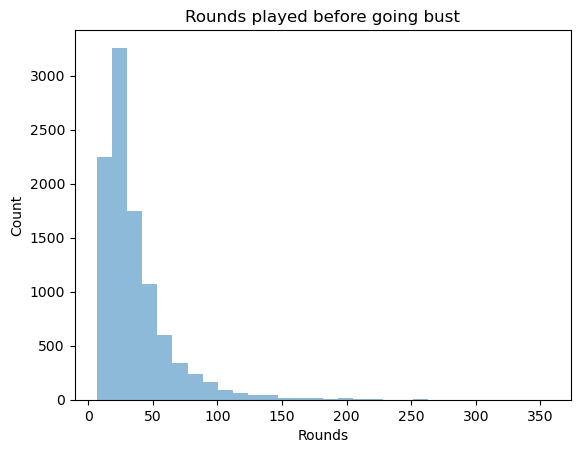

Mean number of hands played before bust 36.3364
Median number of hands played before bust 28.0


In [15]:
plt.hist(durations, bins=30, alpha=0.5)
plt.title('Rounds played before going bust')
plt.xlabel('Rounds')
plt.ylabel('Count')

plt.show()

print(f'Mean number of hands played before bust {np.mean(durations)}')
print(f'Median number of hands played before bust {np.median(durations)}')



,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000115,1785.279673,1806.910694,inf,0.020872,3.240548e-04
burr,0.000127,1660.367263,1689.208624,inf,0.028104,2.701031e-07
beta,0.000315,2321.772384,2350.613746,inf,0.062700,1.278969e-34
gamma,0.000342,2265.345133,2286.976154,inf,0.064908,4.508749e-37
norm,0.001662,5028.371609,5042.792290,inf,0.164910,3.933155e-238


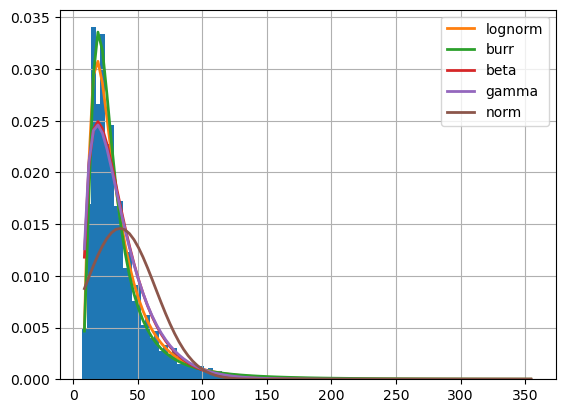

In [16]:
f = Fitter(durations,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [17]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.769711732046881,
  'loc': 5.887713712949166,
  'scale': 22.58938007308915}}

In [18]:
f.fitted_param["lognorm"]

(0.769711732046881, 5.887713712949166, 22.58938007308915)

#### Max bankroll during play

In [19]:
def max_value(inputlist):
    return max([sublist[0] for sublist in inputlist])

peaks = []

for play in play_history:
    peak = max_value(play)
    
    peaks.append(peak)

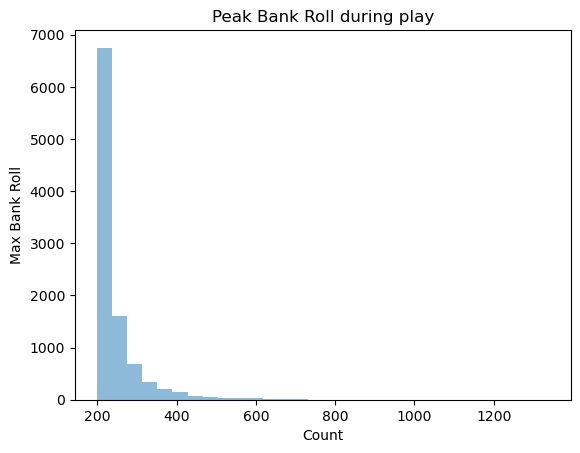

Mean peak bank roll 240.65925
Median peak bank roll 210.0


In [20]:
plt.hist(peaks, bins=30, alpha=0.5)
plt.title('Peak Bank Roll during play')
plt.xlabel('Count')
plt.ylabel('Max Bank Roll')

plt.show()

print(f'Mean peak bank roll {np.mean(peaks)}')
print(f'Median peak bank roll {np.median(peaks)}')


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.000768,3726.994991,3755.836352,inf,0.409925,0.0
burr,0.001006,2606.006690,2634.848052,inf,0.224969,0.0
norm,0.001578,8358.607179,8373.027860,inf,0.288025,0.0
lognorm,0.001826,2063.483289,2085.114310,inf,0.342223,0.0
gamma,0.001844,13736.974099,13758.605120,inf,0.558933,0.0


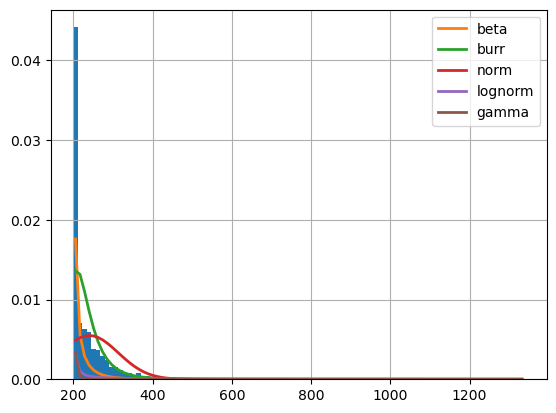

In [21]:
f2 = Fitter(peaks,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f2.fit()
f2.summary()

In [22]:
f2.get_best(method = 'sumsquare_error')

{'beta': {'a': 0.14347323487187014,
  'b': 185.18466890084306,
  'loc': 199.99999999999997,
  'scale': 9931.505002068589}}

In [23]:
f2.fitted_param["beta"]

(0.14347323487187014,
 185.18466890084306,
 199.99999999999997,
 9931.505002068589)

#### Bankroll after r number of rounds

In [24]:
# end bankroll after r rounds
# get rth round in simulation and extract final bankroll

r = 10
rth_round_br = []
for play in play_history:
    if len(play) > r:
        rth_round_br.append(play[r][2])
    else:
        rth_round_br.append(0)

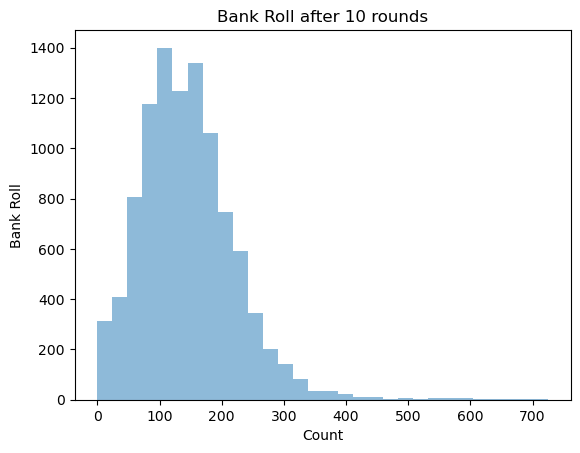

Mean bankroll after 10 rounds 145.004
Median bankroll after 10 rounds 137.5


In [25]:
plt.hist(rth_round_br, bins=30, alpha=0.5)
plt.title(f'Bank Roll after {r} rounds')
plt.xlabel('Count')
plt.ylabel('Bank Roll')

plt.show()

print(f'Mean bankroll after {r} rounds {np.mean(rth_round_br)}')
print(f'Median bankroll after {r} rounds {np.median(rth_round_br)}')

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.000037,1972.393679,2001.235041,inf,0.027596,4.757096e-07
gamma,0.000037,1930.192868,1951.823889,inf,0.028920,1.064014e-07
norm,0.000045,2590.496356,2604.917037,inf,0.059202,6.578062e-31
lognorm,0.000579,2235.970148,2257.601170,inf,0.525141,0.000000e+00
burr,0.001049,1687.648655,1716.490016,inf,0.556262,0.000000e+00


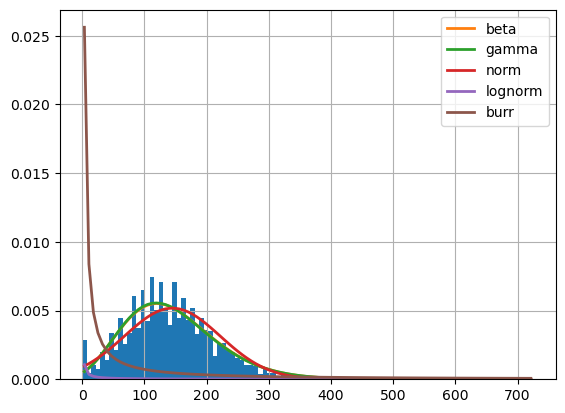

In [26]:
f3 = Fitter(rth_round_br,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f3.fit()
f3.summary()

In [27]:
f3.get_best(method = 'sumsquare_error')

{'beta': {'a': 7.618171316232229,
  'b': 115.63851308930154,
  'loc': -70.66186713850584,
  'scale': 3490.1045667492835}}

In [28]:
f3.fitted_param["gamma"]

(8.464976033139074, -75.06925079875919, 25.998096023158492)

# Odds calculations

#### Rounds until bust

Text(0, 0.5, 'Odds')

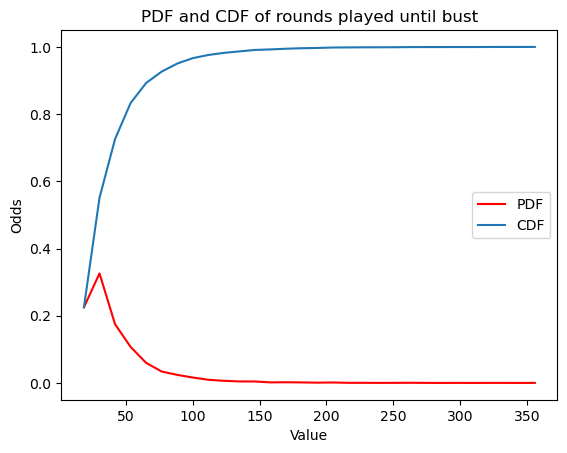

In [43]:
# getting data of the histogram 
count, bins_count = np.histogram(durations, bins = 30) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color = "red", label = "PDF") 
plt.plot(bins_count[1:], cdf, label = "CDF") 
plt.legend() 
plt.title("PDF and CDF of rounds played until bust")
plt.xlabel('Value')
plt.ylabel('Odds')

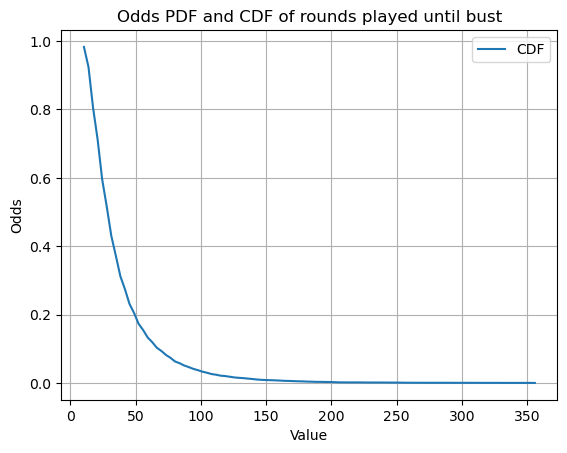

In [30]:
br_odds = 1 - cdf
plt.plot(bins_count[1:], br_odds, label = "CDF") 
plt.legend() 
plt.title('Odds PDF and CDF of rounds played until bust')
plt.xlabel('Value')
plt.ylabel('Odds')
plt.grid()

#### Max bankroll during play

Text(0, 0.5, 'Odds')

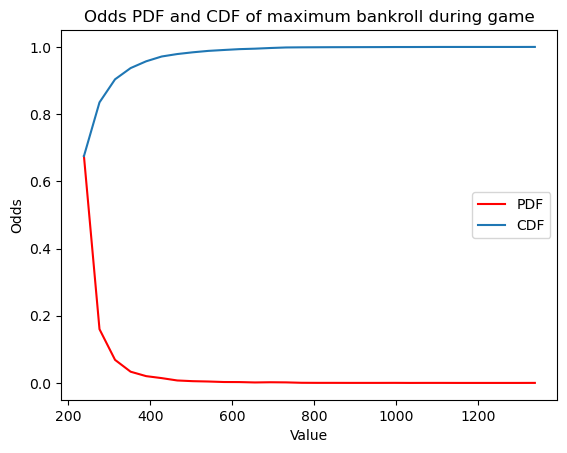

In [44]:
# getting data of the histogram 
count, bins_count = np.histogram(peaks, bins = 30) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color = "red", label = "PDF") 
plt.plot(bins_count[1:], cdf, label = "CDF") 
plt.legend() 
plt.title("Odds PDF and CDF of maximum bankroll during game")
plt.xlabel('Value')
plt.ylabel('Odds')

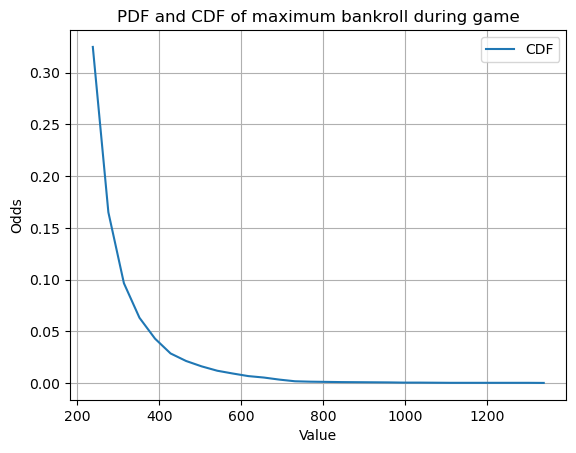

In [45]:
br_odds = 1 - cdf
plt.plot(bins_count[1:], br_odds, label = "CDF") 
plt.legend() 
plt.title('PDF and CDF of maximum bankroll during game')
plt.xlabel('Value')
plt.ylabel('Odds')
plt.grid()

#### Bankroll after r rounds

Text(0, 0.5, 'Odds')

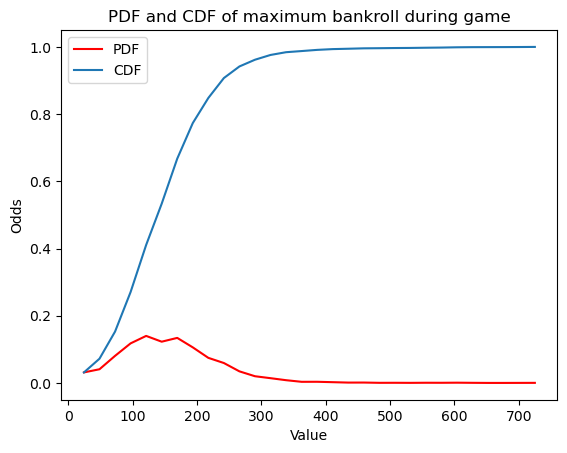

In [46]:
# getting data of the histogram 
count, bins_count = np.histogram(rth_round_br, bins = 30) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color = "red", label = "PDF") 
plt.plot(bins_count[1:], cdf, label = "CDF") 
plt.legend() 
plt.title(f'PDF and CDF of maximum bankroll during game') 
plt.xlabel('Value')
plt.ylabel('Odds')

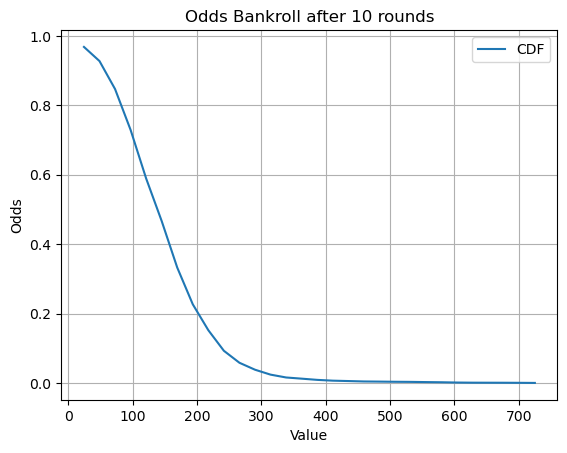

In [47]:
# odds of getting at least a certain amount
br_odds = 1 - cdf
plt.plot(bins_count[1:], br_odds, label = "CDF") 
plt.legend() 
plt.title(f'Odds Bankroll after {r} rounds')
plt.xlabel('Value')
plt.ylabel('Odds')
plt.grid()

# Trips better than no Trips?

Do two separate simulations that are identical other than one will have a trips bet and the other will not. 

In [60]:
num_sims = 10000

# Simulate without trips
ANTE = 5
BLIND = ANTE
play = None
TRIPS = 0
n = 100
bank_roll= 200

play_nt = []

for x in range(num_sims):
    play = play_game_n_rounds(n, bank_roll, deck, ANTE, BLIND, TRIPS)
    play_nt.append(play)

# simulate with trips
ANTE = 5
BLIND = ANTE
play = None
TRIPS = 5
n = 100
bank_roll= 200

play_t = []

for x in range(num_sims):
    play = play_game_n_rounds(n, bank_roll, deck, ANTE, BLIND, TRIPS)
    play_t.append(play)

In [64]:
# Analyze results
durations_nt = []

for play in play_nt:
    durations_nt.append(len(play))

# Analyze results
durations_t = []

for play in play_t:
    durations_t.append(len(play))

print(f'Mean number of hands played before bust with trips {np.mean(durations_nt)}')
print(f'Median number of hands played before bust with trips {np.median(durations_nt)}')
print('\n')
print(f'Mean number of hands played before bust without trips {np.mean(durations_nt)}')
print(f'Median number of hands played before bust without trips {np.median(durations_nt)}')

Mean number of hands played before bust with trips 42.6714
Median number of hands played before bust with trips 38.0


Mean number of hands played before bust without trips 42.6714
Median number of hands played before bust without trips 38.0


In [68]:
# statistical test to show if there is a difference between means
# T-Test, this can be done because sample size is larger than 30

# Perform the t-test:
t_stat, p_value = stats.ttest_ind(durations_nt, durations_nt)

# Interpret the results:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference between betting trips and not betting trips.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between betting trips and not betting trips.")

Fail to reject the null hypothesis; there is no significant difference between betting trips and not betting trips.


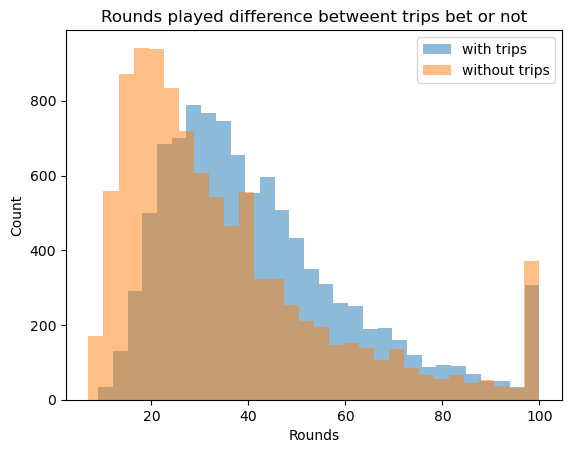

In [62]:
plt.hist(durations_nt, bins=30, alpha=0.5)
plt.hist(durations_t, bins=30, alpha=0.5)
plt.title('Rounds played difference betweent trips bet or not')
plt.xlabel('Rounds')
plt.ylabel('Count')
plt.legend(['with trips', 'without trips'])

# Test Code (ignore)

In [35]:
my_hand = board[0:2]
dealer_hand = board[2:4]
flop = board[4:7]
river = board[7:9]

full_board = board[4:9]

In [36]:
tst_hand = [
    (Rank.TEN, Suit.SPADE),#
    (Rank.JACK, Suit.SPADE),#
    (Rank.THREE, Suit.DIAMOND),
    (Rank.FOUR, Suit.HEART),
    (Rank.FOUR, Suit.SPADE),#
    (Rank.QUEEN, Suit.SPADE),#
    (Rank.KING, Suit.SPADE),#
    (Rank.ACE, Suit.SPADE),#
    (Rank.THREE, Suit.DIAMOND)#
]
my_hand = tst_hand[0:2]
dealer_hand = tst_hand[2:4]
flop = tst_hand[4:7]
river = tst_hand[7:9]

full_hand = HandParser(my_hand + flop + river).handenum

print(get_trips_win(my_hand, flop, river, TRIPS))

print(full_hand)

200
8


In [37]:
my_hand[0][0].name

'TEN'

In [38]:
my_hand
HandParser(my_hand + flop).handenum
my_hand + flop

[(<Rank.TEN: 8>, <Suit.SPADE: 0>),
 (<Rank.JACK: 9>, <Suit.SPADE: 0>),
 (<Rank.FOUR: 2>, <Suit.SPADE: 0>),
 (<Rank.QUEEN: 10>, <Suit.SPADE: 0>),
 (<Rank.KING: 11>, <Suit.SPADE: 0>)]

In [39]:
n = 1
bank_roll= 200
plays = play_game_n_rounds(n, bank_roll, deck, ANTE, BLIND, TRIPS)
print(plays)

[[200, 165, 200, 35, 35]]


In [40]:
hand1 = [
    (Rank.KING, Suit.SPADE),
    (Rank.JACK, Suit.SPADE)
]
hand1[1][0].value

9

In [41]:
hand1[1][0].value

9